# Ground-State Variational Search with NetKet

23 august 2021 

In this Tutorial we will introduce the open-source package [NetKet](https://www.netket.org/), and show some of its functionalities. We will guide you through a relatively simple quantum problem, that however will be a good guide also to address more complex situations. 

Specifically, we will study the transverse-field Ising model in one dimension: 

$$ 
\mathcal{H}=\Gamma\sum_{i}\sigma_{i}^{(x)}+V\sum_{i}\sigma_{i}^{(z)}\sigma_{i+1}^{(z)}. 
$$

In the following we assume periodic boundary conditions and we will count lattice sites starting from $ 0 $, such that $ i=0,1\dots L-1 $ and $i=L=0$. 

## 0. Installing Netket 

Installing NetKet is relatively straightforward. For this Tutorial, if you are running it locally on your machine, we recommend that you create a clean virtual environment and install NetKet within: 

```bash
python3 -m venv netket
source netket/bin/activate
pip install --upgrade netket
```

**If you are on Google Colab**, run the following cell to install the required packages.

In [ ]:
!pip install --upgrade netket

You can check that the installation was succesfull doing 

In [1]:
import netket as nk

You should also check that your version of netket is at least 3.0

In [2]:
print(f"NetKet version: {nk.__version__}")

NetKet version: 3.0b4.post1


## 1. Defining The Hamiltonian

The first step in our journey consists in defining the Hamiltonian we are interested in. 
For this purpose, we first need to define the kind of degrees of freedom we are dealing with (i.e. if we have spins, bosons, fermions etc). This is done specifying the Hilbert space of the problem. For example, let us concentrate on a problem with 20 spins. 

In [3]:
N = 20

hi = nk.hilbert.Spin(s=1 / 2, N=N)

We now need to specify the Hamiltonian. For this purpose, we will use NetKet's ```LocalOperator``` (see details [here](https://www.netket.org/docs/_generated/operator/netket.operator.LocalOperator.html#netket.operator.LocalOperator)) which is the sum of arbitrary k-local operators. 

In this specifc case, we have a 1-local operator, $ \sigma^{(x)}_i $ and a 2-local operator, $ \sigma^{(z)}_i \sigma^{(z)}_j $. We then start importing the pauli operators. 



In [4]:
from netket.operator.spin import sigmax,sigmaz 

We now take $ \Gamma=-1 $ and start defining the 1-local parts of the Hamiltonian 

In [5]:
Gamma = -1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])

Here we have used a list comprehension to (mildly) show off our ability to write one-liners, however you could have just added the terms one by one in an explicit loop instead (though you'd end up with a whopping 3 lines of code). 

We now also add the interaction terms, using the fact that NetKet automatically recognizes products of local operators as tensor products. 

In [6]:
V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

In general, when manipulating NetKet objects, you should always assume that you can safely operate on them like 
you would in mathematical equations, therefore you can sum and multiply them with ease.

## 2. Exact Diagonalization

Now that we have defined the Hamiltonian, we can already start playing with it. For example, since the number of spins is large but still manageable for exact diagonalization, we can give it a try. 

In NetKet this is easily done converting our Hamiltonian operator into a sparse matrix of size $ 2^N \times 2^ N $. 

In [7]:
sp_h=H.to_sparse()
sp_h.shape

(1048576, 1048576)

Since this is just a regular scipy sparse matrix, we can just use any sparse diagonalization routine in there to find the eigenstates. For example, this will find the two lowest eigenstates  

In [8]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)

E_gs = eig_vals[0]

eigenvalues with scipy sparse: [-25.49098969 -25.41240947]


## 3. Mean-Field Ansatz

We now would like to find a variational approximation of the ground state of this Hamiltonian. As a first step, we can try to use a very simple mean field ansatz: 

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(\sigma^{z}_i), $$

where the variational parameters are the single-spin wave functions, which we can further take to be normalized: 

$$ |\Phi(\uparrow)|^2 + |\Phi(\downarrow)|^2 =1, $$

and we can further write $ \Phi(\sigma^z) = \sqrt{P(\sigma^z)}e^{i \phi(\sigma^z)}$. In order to simplify the presentation, we take here and in the following examples the phase $ \phi=0 $. In this specific model this is without loss of generality, since it is known that the ground state is real and positive. 

For the normalized single-spin probability we will take a sigmoid form: 

$$ P(\sigma_z; \lambda) = 1/(1+\exp(-\lambda \sigma_z)), $$ thus depending on the real-valued variational parameter $\lambda$. 

In NetKet one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).
We call this variational function _the Model_ (yes, caps on the M).

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \exp\left[\mathrm{Model}(\sigma^{z}_1,\dots \sigma^{z}_N ; \theta ) \right], $$ where $\theta$ is a set of parameters. 

In this case, the parameter of the model will be just one: $\gamma$.  

The Model can be defined using one of the several *functional* jax frameworks such as Jax/Stax, Flax or Haiku. 
NetKet includes several pre-built models and layers built with [Flax](https://github.com/google/flax), so we will be using it for the rest of the notebook. 

In [9]:
# numerical operations in the model should always use jax.numpy 
# instead of numpy because jax supports computing derivatives. 
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

# A Flax model must be a class subclassing `nn.Module`
class MF(nn.Module):
    
    # The most compact way to define the model is this.
    # The __call__(self, x) function should take as 
    # input a batch of states x.shape = (n_samples, L)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):
        
        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values. 
        # - The shape of the tensor
        # - The dtype of the tensor.
        lam = self.param(
            "lambda", nn.initializers.normal(), (1,), float
        )
        
        # compute the probabilities
        p = nn.log_sigmoid(lam*x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

The model itself is only a set of instructions on how to initialise the parameters and how to compute the result. 

To actually create a variational state with its parameters, the easiest way is to construct a Monte-Carlo-sampled Variational State. 
To do this, we first need to define a sampler.

In `netket.sampler` several samplers are defined, each with its own peculiarities. 
In the following example, we will be using a simple sampler that flips the spins in the configurations one by one.

You can read more about how the sampler works by checking the documentation with `?nk.sampler.MetropolisLocal`

In [10]:
# Create an instance of the model. 
# Notice that this does not create the parameters.
mf_model=MF()

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=500)

In [11]:
# you can inspect the parameters which contain the single
# variational parameter `lambda`
print(vstate.parameters)

FrozenDict({
    lambda: DeviceArray([0.00730014], dtype=float64),
})


In [12]:
# Expectation value: notice that it also provides an error estimate.
print(vstate.expect(H))

-19.88 ± 0.20 [σ²=20.60, R̂=1.0043]


## 4. Variational Monte Carlo

We will now try to optimise $ \lambda $ in order to best approximate the ground state of the hamiltonian.

To do so, first I need to pick an iterative optimiser. We choose stochastic gradient descent with a learning
rate of $0.05$.
Then, we must provide all the elements to the variational monte carlo driver, which takes case of setting up and running the whole optimisation.

In [13]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# run the driver for 300 iterations. This will display a progress bar
# by default.
gs.run(n_iter=300)

mf_energy=vstate.expect(H)
error=abs((mf_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",mf_energy,error)

No output specified (out=[apath|nk.logging.JsonLogger(...)]).Running the optimization but not saving the output.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:07<00:00, 40.90it/s, Energy=-24.940 ± 0.045 [σ²=1.040, R̂=1.0065]]


Optimized energy and relative error:  -24.948 ± 0.044 [σ²=0.996, R̂=0.9979] 0.021311465905007886


In [14]:
# we can also inspect the parameter:
print("Final optimized parameter: ",vstate.parameters["lambda"])

Final optimized parameter:  [2.63471166]


## 5. Jastrow Ansatz

We have seen that the mean field ansatz yields about 2% error on the ground-state energy. Let's now try to do better, using a more correlated ansatz. 

We will now take a short-range Jastrow ansatz, entangling nearest and next-to nearest neighbors, of the form 

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{jas}} \rangle = \exp \left( \sum_i J_1 \sigma^{z}_i\sigma^{z}_{i+1} + J_2 \sigma^{z}_i\sigma^{z}_{i+2} \right),$$

where the parameters $J_1$ and $J_2$ are to be learned. 

Again we can write the model using flax. 

In [15]:
class JasShort(nn.Module):
    @nn.compact
    def __call__(self, x):
        
        # Define the two variational parameters J1 and J2
        j1 = self.param(
            "j1", nn.initializers.normal(), (1,), float
        )
        j2 =self.param(
            "j2", nn.initializers.normal(), (1,), float
        )

        # compute the nearest-neighbor correlations
        corr1=x*jnp.roll(x,-1,axis=-1)
        corr2=x*jnp.roll(x,-2,axis=-1)

        # sum the output
        return jnp.sum(j1*corr1+j2*corr2,axis=-1)
    
model=JasShort()

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

We then optimize it, however this time we also introduce a stochastic reconfiguration (natural gradient) preconditioner. Also, we now log the intermediate results of the optimization, so that we can visualize them at a later stage. 

In [16]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.1))

# Loggers that work together with optimisation drivers are defined in nk.logging.
# RuntimeLog keeps the metrics in memory, JsonLog stores them to a json file which can be read
# as a dict, TensorBoardLog can be used to log to TensorBoard.
log=nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log)

print(f"Final optimized parameters: j1={vstate.parameters['j1']}, j2={vstate.parameters['j2']}")

jas_energy=vstate.expect(H)
error=abs((jas_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {error}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:07<00:00, 41.35it/s, Energy=-25.304 ± 0.020 [σ²=0.411, R̂=1.0135]]


Final optimized parameters: j1=[0.23291901], j2=[0.08249868]
Optimized energy : -25.332 ± 0.020 [σ²=0.414, R̂=1.0046]
relative error   : 0.006217843960984178


You can now see that this ansatz is almost one order of magnitude more accurate than the mean field! 

In order to visualize what happened during the optimization, we can use the data that has been stored by the logger. There are several available loggers in NetKet, here we have just used a simple one that stores the intermediate results as values in a dictionary. 

In [17]:
data_jastrow = log.data
print(data_jastrow)

{'Energy': History(
   keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], 
   iters = [0, 1, ... 298, 299] (300 steps),
)}


These report several intermediate quantities, that can be easily plotted. For example we can plot the value of the energy (with its error bar) at each optimization step.  

Text(0, 0.5, 'Energy')

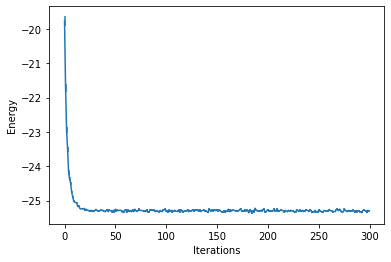

In [18]:
from matplotlib import pyplot as plt

plt.errorbar(data_jastrow["Energy"].iters, data_jastrow["Energy"].Mean, yerr=data_jastrow["Energy"].Sigma)
plt.xlabel('Iterations')
plt.ylabel('Energy')

## 6. Neural-Network Quantum State 

We now want to use a more sofisticated ansatz, based on a neural network representation of the wave function. At this point, this is quite straightforward, since we can again take advantage of automatic differentiation. 

Let us define a simple fully-connected feed-forward network with a ReLu activation function and a sum layer. 

In [19]:
class FFN(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module.
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # WARNING: Won't work with complex hamiltonians because
        # of a bug in flax. Use nk.nn.Dense otherwise. 
        dense = nn.Dense(features=self.alpha * x.shape[-1])
        
        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)
        
        # sum the output
        return jnp.sum(y, axis=-1)
    
model = FFN(alpha=1)

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

*Warning*: Flax has a bug with its layers, where they drop the imaginary part
of complex numbers if the layer has real weights.
This is not a problem in the above example, but if you try to work on more complex
problems where you work with complex numbers you should rather use the equivalent 
`nk.nn.Dense` which contains a fix for this bug.

We then proceed to the optimization as before. 

In [20]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)

ffn_energy=vstate.expect(H)
error=abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",ffn_energy,error)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:08<00:00, 33.98it/s, Energy=-25.480 ± 0.011 [σ²=0.118, R̂=0.9995]]


Optimized energy and relative error:  -25.501 ± 0.012 [σ²=0.150, R̂=0.9964] 0.000406655916988611


And we can compare the results between the two different ansatze:

Text(0, 0.5, 'Energy')

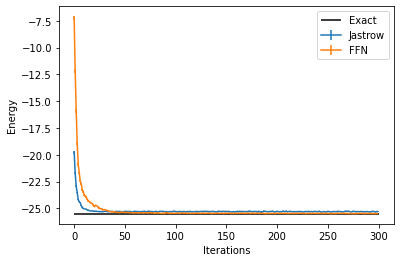

In [21]:
data_FFN = log.data

plt.errorbar(data_jastrow["Energy"].iters, data_jastrow["Energy"].Mean, yerr=data_jastrow["Energy"].Sigma, label="Jastrow")
plt.errorbar(data_FFN["Energy"].iters, data_FFN["Energy"].Mean, yerr=data_FFN["Energy"].Sigma, label="FFN")
plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

## 7. Translation Symmetry 

In order to enforce spatial symmetries we can use some built-in functionalities of NetKet, in conjunction with equivariant layers. 

The first step is to construct explicitly a graph that contains the edges of our interactions, in this case this is a simple chain with periodic boundaries. NetKet has builtin several symmetry groups that can be used to target specific spatial symmetries. In this case for example after constructing the graph we can also print its translation group. 


In [22]:
graph=nk.graph.Chain(length=N, pbc=True)

print(graph.translation_group())

PermutationGroup(elems=[Id(), Translation([1]), Translation([2]), Translation([3]), Translation([4]), Translation([5]), Translation([6]), Translation([7]), Translation([8]), Translation([9]), Translation([10]), Translation([11]), Translation([12]), Translation([13]), Translation([14]), Translation([15]), Translation([16]), Translation([17]), Translation([18]), Translation([19])], degree=20)


Graphs are in general quite handy when defining hamiltonian terms on their edges. For example we can define our Hamiltonian as 

In [23]:
Gamma=-1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])

V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in graph.edges()])

We now write a model with an invariant transformation given by the translation group. Notice that we will now use NetKet's own ```nn``` module, instead of Flax, since it contains several additions and also an extended and seamless support for complex layers/parameters.  

In [24]:
import netket.nn as nknn

class SymmModel(nn.Module):
    alpha: int

    @nn.compact
    def __call__(self, x):
        
        x = nknn.DenseSymm(symmetries=graph.translation_group(),
                           features=self.alpha,
                           kernel_init=nk.nn.initializers.normal(stddev=0.01))(x)
        x = nn.relu(x)

        # sum the output
        return jnp.sum(x,axis=(-1,-2))


sampler = nk.sampler.MetropolisLocal(hi)

#Let us define a model with 4 features per symmetry
model=SymmModel(alpha=4)

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

vstate.n_parameters

84

As it can be seen, the number of parameters of this model is greatly reduced, because of the symmetries that impose constraints on the weights of the dense layers. We can now optimize the model, using a few more optimization steps than before.  

In [25]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=600,out=log)

symm_energy=vstate.expect(H)
error=abs((symm_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",symm_energy,error)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:30<00:00, 19.58it/s, Energy=-25.4888 ± 0.0014 [σ²=0.0020, R̂=1.0006]]


Optimized energy and relative error:  -25.4910 ± 0.0015 [σ²=0.0024, R̂=1.0010] 1.8086847978220319e-06


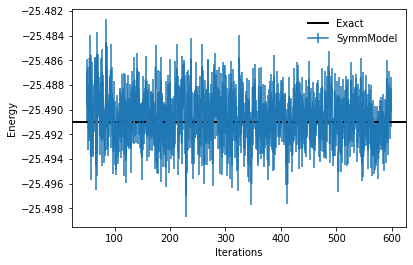

In [26]:
plt.errorbar(log.data["Energy"].iters[50:],log.data["Energy"].Mean[50:],yerr=log.data["Energy"].Sigma[50:],label="SymmModel")

plt.axhline(y=eig_vals[0], xmin=0, xmax=log.data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)

## 8. Measuring Other Properties

Once the model has been optimized, we can of course measure also other observables that are not the energy. For example, we could decide to measure the value of the nearest-neighbor $X-X$ correlator. 
Notice that since correlators do not enjoy the zero-variance principle as the Hamiltonian instead does, it is important to use a larger number of samples to have a sufficiently low error bar on their measurement. 


In [27]:
corr = sum([sigmax(hi,i)*sigmax(hi,j) for (i,j) in graph.edges()])

In [28]:
vstate.n_samples=400000

In [29]:
vstate.expect(corr)

10.858 ± 0.018 [σ²=31.582, R̂=1.0000]

And we can further compare this to the exact ED result. 

In [30]:
psi = eig_vecs[:, 0]
exact_corr=psi@(corr.to_sparse()@psi)
print(exact_corr)

10.85224871312767


## 9. Learning the Phase of the Wave Function

In the examples shown before we have ignored completely the phase of the wave function, since we were working with a Hamiltonian whose ground-state has a definite sign. 
We now generalize the previous discussion and study a model, the Heisenberg model

$$ \mathcal{H}= J\sum_{i}\vec{\sigma}_{i}\cdot \vec{\sigma}_{i+1}^. $$

that has a non-trivial sign structure for the ground state. 

Training models with a phase is significantly less trivial than optimizing phaseless models, thus we will adopt here a heuristic approximation approach that has proven quite robust. What we will do here is that we will train the model using different (and time-dependent) learning rates for the phase and modulus parts of the wave function. The learning schedule rate is chosen in such as way that in the firs stages we will optimize mostly only the phase, while leaving the amplitude more or less constant. The schedule then will ramp up the learning rate for the amplitude and we will optimize everything at the same time. 

For the moment, we start defining our Hamiltonian (with $J=1$), and we also focus on the sector with vanishing total spin, since we know that the ground state is in this sector :  

In [31]:
# We define an hilbert space for N spins with total magnetization fixed at 0.
hi = nk.hilbert.Spin(s=1 / 2, N=N, total_sz=0)

from netket.operator.spin import sigmax, sigmaz, sigmay

graph = nk.graph.Chain(length=N, pbc=True)

def exchange(i, j):
    return (
        sigmax(hi, i) * sigmax(hi, j)
        + sigmay(hi, i) * sigmay(hi, j)
        + sigmaz(hi, i) * sigmaz(hi, j)
    )


H = sum([exchange(i, j) for (i, j) in graph.edges()])

Since we fixed the magnetization, random states generated by the hilbert space will 
have 0 magnetization. See below:

In [35]:
import jax 

v = hi.random_state(jax.random.PRNGKey(0), (2,))

print("The total magnetization for those two states are: ", v.sum(axis=-1))

The total magnetization for those two states are:  [0. 0.]


As before, we also compute the exact energy, for future benchmarking. 

In [36]:
sp_h = H.to_sparse().real

from scipy.sparse.linalg import eigsh
import numpy as np

print("diagonalizing...")
eig_vals = np.sort(eigsh(sp_h, k=4, which="SA", return_eigenvectors=False, tol=1.0e-8))

print("eigenvalues with scipy sparse:", eig_vals)

diagonalizing...
eigenvalues with scipy sparse: [-35.61754612 -34.74576394 -34.21753829 -33.63032594]


We then define a symmetric neural network model as before, but this time we also allow for another real-valued network that represents the phase: 

In [40]:
import flax.linen as nn
import netket.nn as nknn
import jax.numpy as jnp

class FullModel(nn.Module):

    alpha: int

    @nn.compact
    def __call__(self, x):
        
        # We use a symmetrized dense layer, and the symmetries are given
        # by the translational group on our lattice
        rho = nknn.DenseSymm(
            symmetries=graph.translation_group(),
            features=self.alpha,
            dtype=float,
            kernel_init=nn.initializers.normal(stddev=0.001),
            name="Modulus"
        )(x)
        rho = nn.relu(rho)
        
        # We use nknn.Dense and not nn.Dense because the latter has a bug
        # with complex number inputs
        phase= nknn.Dense(
            features=self.alpha*N,
            dtype=float,
            kernel_init=nn.initializers.normal(stddev=0.001),
            name="Phase"
        )(x)
        phase = nn.relu(phase)

        return jnp.sum(rho, axis=(-1, -2)) + 1.0j*jnp.sum(phase, axis=(-1))

We then construct a suitable Variational State, using this model (with the phase only, for the moment) and also a sampler that preserves the total magnetization. For the latter, we will use a MCMC sampler that exchanges spins at random, thus preserving the total magnetization. 

In [42]:
model = FullModel(alpha=4)

# MetropolisLocal does not conserve the total magnetization of the states initially imposed by
# the hilbert space. MetropolisExchange, instead, exchanges the population at two sites so 
# it does.
sampler = nk.sampler.MetropolisExchange(hi, graph=graph)

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

We then proceed to the optimization of the phase only. This is achieved the scheduling functionalities of  ```optax```, the optimization library that is fully compatible with NetKet. Notice that here we start with zero learning rate for the modulus and fintie learning rate for the phase. 

In [47]:
import optax,flax

# A linear schedule varies the learning rate from 0 to 0.01 across 600 steps.
modulus_schedule=optax.linear_schedule(0,0.01,600)

# The phase starts with a larger learning rate and then is decreased.
phase_schedule=optax.linear_schedule(0.05,0.01,600)

# Combine the linear schedule with SGD
optm=optax.sgd(modulus_schedule)
optp=optax.sgd(phase_schedule)

# The multi-transform optimizer uses different optimisers for different parts of the
# parameters.
optimizer = optax.multi_transform({'o1': optm, 'o2': optp}, 
                flax.core.freeze({"Modulus":"o1", "Phase":"o2"}))

We then use this advanced optimizer as usual in our VMC code. 

In [45]:
gs = nk.driver.VMC(
    H,
    optimizer,
    variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1)
)

log = nk.logging.RuntimeLog()
gs.run(n_iter=600, out=log)

100%|████████████████████████████████████████████████████████████████████████████████████████| 600/600 [01:10<00:00,  8.47it/s, Energy=-35.610-0.000j ± 0.011 [σ²=0.120, R̂=0.9977]]


(<netket.logging.runtime_log.RuntimeLog at 0x1487fc910>,)

Optimized energy and relative error:  -35.600+0.001j ± 0.010 [σ²=0.104, R̂=1.0037] 0.0005007882608163399


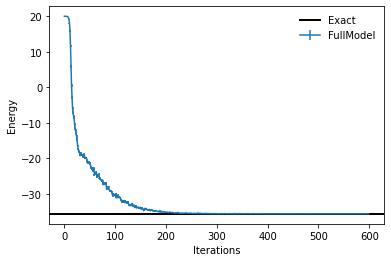

In [46]:
symm_energy=vstate.expect(H)
error=abs((symm_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",symm_energy,error)


from matplotlib import pyplot as plt
plt.errorbar(log.data["Energy"].iters,log.data["Energy"].Mean.real,yerr=log.data["Energy"].Sigma,label="FullModel")
plt.axhline(y=eig_vals[0], xmin=0, xmax=log.data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)